# packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import datetime

from scipy.stats.stats import pearsonr
from scipy.stats import linregress
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
import networkx as nx
import pylab

## nbextension

# import data

In [2]:
# Path for OM data
df_om = pd.read_csv('../1 Input Data/export_group_OM_20200714.csv')

In [3]:
# Path for wearables data
df_cgn = pd.read_csv(
    '../1 Input Data/20200206_CGN_1901_data_anon.csv')

# data preprocessing

## filter not_set

In [4]:
df_om = df_om.replace('not_set', np.nan)
df_cgn = df_cgn.replace('not_set', np.nan)

## lifestyle features

In [5]:
lifestyle_features = [
    #              'test_date',
    #          'test_local_date',
    #          'test_local_date_dt',
    #          'test_local_date_hour',
    #          'test_local_date_day_of_week',

    #          'mood', #contains NANs
    #          'sleep_hours', #contains NANs PERHAPS
    #          'inbed_hours', #contains NANs
    #          'stand_hours', #contains NANs

    'stimulant_doze',
    'sleep_time',

    'alcohol_doze',
    'heart_rate_avg',
    'heart_rate_resting_avg',
    'heart_rate_walking_avg',
    'energy_burned_active',
    'energy_burned_resting',
    'steps_count',
    'walking_distance',
    'exercise_hours',
    'climbed_flights_count',
    #          'active_energy_preceding_24hrs',
    #          'active_energy_preceding_7_days',
    #          'basal_energy_preceding_7_days',
    #          'basal_energy_preceding_24hrs',
    #          'steps_preceding_7_days',
    #          'steps_preceding_24hrs',
    #          'hrv_preceding_24hrs',
    #          'hrv_preceding_1hr',
]

score_lifestyle_features = [
    
    'score',
    #              'test_date',
    #          'test_local_date',
    #          'test_local_date_dt',
    #          'test_local_date_hour',
    #          'test_local_date_day_of_week',

    #          'mood', #contains NANs
    #          'sleep_hours', #contains NANs PERHAPS
    #          'inbed_hours', #contains NANs
    #          'stand_hours', #contains NANs

    'stimulant_doze',
    'sleep_time',

    'alcohol_doze',
    'heart_rate_avg',
    'heart_rate_resting_avg',
    'heart_rate_walking_avg',
    'energy_burned_active',
    'energy_burned_resting',
    'steps_count',
    'walking_distance',
    'exercise_hours',
    'climbed_flights_count',
    #          'active_energy_preceding_24hrs',
    #          'active_energy_preceding_7_days',
    #          'basal_energy_preceding_7_days',
    #          'basal_energy_preceding_24hrs',
    #          'steps_preceding_7_days',
    #          'steps_preceding_24hrs',
    #          'hrv_preceding_24hrs',
    #          'hrv_preceding_1hr',
]

## str preprocessing

### e.g. mood

In [6]:
df_om[['mood']].describe()

mood
count   398
unique    9
top       7
freq    128

In [7]:
df_om['mood'].unique()

array([nan, '8', '6', '7', '5', '4', '2', '9', '10', '3'], dtype=object)

In [8]:
(df_om.mood.apply(lambda x: np.nan if x==np.nan else float(x))).unique()

array([nan,  8.,  6.,  7.,  5.,  4.,  2.,  9., 10.,  3.])

In [9]:
df_om['mood'] = df_om.mood.apply(lambda x: np.nan if x==np.nan else float(x))

## features str to float

In [10]:
def str2float(df, features):
#     print(df[f].unique())
    for f in features:
        df[f] = df[f].apply(lambda x: np.nan if x==np.nan else float(x))
    return df
    
# for f in lifestyle_features:
#     print(f)
df_om = str2float(df_om, lifestyle_features)
df_cgn = str2float(df_cgn, lifestyle_features)

## datetime preprocessing

In [11]:
# need to make test time in the day FLOAT? or make time a one hot vec?

## combine datasets

In [12]:
df_data = pd.concat([df_om, df_cgn],
                    sort=False)

In [13]:
df_data = df_data.reset_index()
df_data['test_number'] = df_data.sort_values(
    by=['user_id', 'test_date']).groupby(by='user_id').cumcount()+1

## valid user_ids

In [14]:
df_om.groupby(by='user_id').score.count(), df_cgn.groupby(by='ID').score.count()

(user_id
 13    94
 15    17
 18    50
 19    10
 27    25
 28    16
 29    21
 35    23
 37    14
 38    11
 40    43
 49    14
 51    42
 54     4
 55    57
 58     4
 60     3
 66    14
 67    14
 71    13
 72     4
 73     3
 Name: score, dtype: int64,
 ID
 S01     85
 S02     78
 S03     96
 S04      9
 S05     85
 S06     89
 S07    106
 S08    108
 S09    112
 S10     96
 S11     98
 S12    105
 S13     91
 Name: score, dtype: int64)

In [15]:
# todo select if tests_count > 40

valid_ids = [13, 18, 40,
             #              51, ###
             55]
valid_IDs = ['S01', 'S02', 'S03', 'S05', 'S06',
             'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13']

## make user_id

In [16]:
set.intersection(
    set(df_om.user_id.unique()), set(df_cgn.user_id.unique())
)

# so we'll use df_cgn.ID and df_om.user_id

{49, 54, 55}

In [17]:
# df_data.user_id = df_data.ID
df_data.loc[490:510][['ID', 'user_id']]
# df_data['iidd'] = df_data['ID']
# df_data['iidd']

ID  user_id
490  NaN       72
491  NaN       72
492  NaN       72
493  NaN       73
494  NaN       73
495  NaN       73
496  S01       57
497  S01       57
498  S01       57
499  S01       57
500  S01       57
501  S01       57
502  S01       57
503  S01       57
504  S01       57
505  S01       57
506  S01       57
507  S01       57
508  S01       57
509  S01       57
510  S01       57

### combine ids

# mutual information

## information
The [entropy][1] of a random variable $X$ is just another number summarizing some quality of that random variable.  Just like the mean of a random variable is the expected value of $X$ or the variance of a random variable is the expected value of $(X - \mu)^2$, the entropy is just the expected value of some function, $f(X)$ of the random variable $X$.  You find expectations of functions by using
$\mathbb{E}[f(X)] = \sum_{x\in X}p(x)f(x).$  In this case the function of $X$ you care about is the log (base 2) of the probability mass function.

$$ H(X) = \mathbb{E}[-\log_2 P(X)] = -\sum_{x \in X} p(x) \log_2 p(x).$$

This particular expectation is useful because it **doesn't depend on the actual values** that $X$ can take on, **just the probabilities** of those values.  So you can use it to talk about situations where you aren't sending numbers, or where the numbers are just arbitrarily assigned to particular messages or symbols that you need to send.

Information = Entropy = Surprise = Uncertainty = How Much You Learn By Making an Observation.  They all increase or decrease together. 

----------
  
  [1]: https://en.wikipedia.org/wiki/Entropy_%28information_theory%29
  
source: [CS.StackExchange: Conceptual question about entropy and information](https://cs.stackexchange.com/questions/28756/conceptual-question-about-entropy-and-information)

---

## mutual information
Mutual information $I(X, Y)$ can be thought as a measure of reduction in uncertainty about $X$ after observing $Y$:

$$ I(X, Y) = H(X) - H(X|Y)$$

where $H(X)$ is entropy of $X$ as mentioned, and $H(X|Y)$ is [conditional entropy][2] of $X$ given $Y$. By symmetry it follows that

$$ I(X, Y) = H(Y) - H(Y|X)$$

  [2]: https://en.wikipedia.org/wiki/Conditional_entropy


In [18]:
def mutual_info_features(df, f1, f2):
    df = df[~df[f1].isna() & ~df[f2].isna()]
    if df.size == 0:
        return np.nan
    return mutual_info_regression(df[f1].values.reshape(-1, 1),
                                  df[f2].values)[0]

In [19]:
def information(df, features):
    information = {}
    for f in features:
        information[f] = mutual_info_features(df, f, f)
    return information


pd.DataFrame.from_dict(information(df_om,
                                   lifestyle_features),
                       orient='index', columns=['information'])

information
stimulant_doze             1.853251
sleep_time                 1.395256
alcohol_doze               0.813831
heart_rate_avg             3.061700
heart_rate_resting_avg     2.289662
heart_rate_walking_avg     2.318063
energy_burned_active       3.001849
energy_burned_resting      3.016279
steps_count                4.328461
walking_distance           4.334426
exercise_hours             2.556025
climbed_flights_count      2.672051

In [20]:
# todo values should be smoothed: 1000 steps not dif with 1001 steps!

Mutual information of a variable with itself is equal to entropy of variable $I$, and is called [self-information][3].

$$ I(X, X) = H(X)$$

This is true since $H(X|Y) = 0$ if values of $X$ are completely determined by $Y$ and this is true for $H(X|X)$. It is so because entropy is a measure of uncertainty and there is no uncertainty in reasoning on values of $X$ *given* the values of $X$, so

$$ X(X) - X(X|X) = X(X) - 0 = H(X) $$

This is immediately obvious if you think of it in terms of Venn diagrams as illustrated below.

![enter image description here][4]

You can also show this using the formula for mutual information and substituting the conditional entropy part, i.e.

$$ H(X|Y) = \sum_{x \in X, y \in Y} p(x, y) \log \frac{p(x,y)}{p(x)} $$

So yes, if you know something about $X$, then learning again about $X$ gives you no more information.


  [3]: https://en.wikipedia.org/wiki/Self-information
  [4]: http://i.stack.imgur.com/CL3iX.png
  [5]: https://en.wikipedia.org/wiki/Set_(mathematics)
  [6]: https://math.stackexchange.com/questions/1749370/joint-distribution-of-x-with-itself/1749389
  [7]: https://web.cse.msu.edu/~cse842/Papers/CoverThomas-Ch2.pdf
  [8]: http://worrydream.com/refs/Shannon%20-%20A%20Mathematical%20Theory%20of%20Communication.pdf
 
----------

Check [Chapter 2][7] of *Elements of Information Theory*  by Cover and Thomas, or [Shanon's original 1948 paper][8] itself for learning more.

source: [Stats.StackExchange: Why would perfectly similar data have 0 mutual information?](https://stats.stackexchange.com/questions/161429/why-would-perfectly-similar-data-have-0-mutual-information)

In [21]:
def mutual_infos(df):
    """Calculate the mutual information for lifestyle_features in a given dataframe

    Args:
        df: Ahe dataframe we want mutual information between its columns.
    Returns:
        A dataframe contating mutual informations.
    Raises:
        TypeError: if df is not a pandas dataframe.
        ValueError: if df has no columns.

    """
    mutual_infos = {}
    for f1 in lifestyle_features:
        temp_f1 = {}
        for f2 in lifestyle_features:
            #             if f1 == f2:
            #                 temp_f1[f2] = np.nan
            #             else:
            temp_f1[f2] = mutual_info_features(df, f1, f2)
        mutual_infos[f1] = temp_f1

    return pd.DataFrame(mutual_infos)

In [22]:
mutual_infos_om = mutual_infos(df_om)
mutual_infos_om

stimulant_doze  sleep_time  alcohol_doze  \
stimulant_doze                1.830975    0.064850      0.037978   
sleep_time                    0.019570    1.420259      0.020294   
alcohol_doze                  0.014087    0.000000      0.901863   
heart_rate_avg                0.093603    0.040991      0.039566   
heart_rate_resting_avg        0.215344    0.000000      0.009594   
heart_rate_walking_avg        0.151240    0.093488      0.066848   
energy_burned_active          0.137257    0.106898      0.062404   
energy_burned_resting         0.174170    0.112275      0.105806   
steps_count                   0.133336    0.050161      0.021496   
walking_distance              0.078532    0.035362      0.036887   
exercise_hours                0.183685    0.040394      0.089441   
climbed_flights_count         0.132105    0.091214      0.051735   

                        heart_rate_avg  heart_rate_resting_avg  \
stimulant_doze                0.098860                0.157402   
sleep_time                    0.048022                0.019216   
alcohol_doze                  0.000000                0.066981   
heart_rate_avg                3.048777                0.701814   
heart_rate_resting_avg        0.695511                2.295443   
heart_rate_walking_avg        0.612994                0.544191   
energy_burned_active          0.730127                0.640559   
energy_burned_resting         0.701254                0.603692   
steps_count                   0.327365                0.370162   
walking_distance              0.373146                0.376811   
exercise_hours                0.673300                0.439143   
climbed_flights_count         0.371319                0.295806   

                        heart_rate_walking_avg  energy_burned_active  \
stimulant_doze                        0.146663              0.130384   
sleep_time                            0.041173              0.072686   
alcohol_doze                          0.087666              0.074140   
heart_rate_avg                        0.600995              0.701271   
heart_rate_resting_avg                0.573124              0.624357   
heart_rate_walking_avg                2.248153              0.499891   
energy_burned_active                  0.472919              3.047348   
energy_burned_resting                 0.599686              0.983669   
steps_count                           0.355922              0.850410   
walking_distance                      0.304988              0.979886   
exercise_hours                        0.410453              0.845332   
climbed_flights_count                 0.334879              0.514657   

                        energy_burned_resting  steps_count  walking_distance  \
stimulant_doze                       0.180253     0.136118          0.089687   
sleep_time                           0.111701     0.032221          0.013020   
alcohol_doze                         0.159655     0.036542          0.067646   
heart_rate_avg                       0.669531     0.368924          0.383362   
heart_rate_resting_avg               0.616584     0.373863          0.378453   
heart_rate_walking_avg               0.512019     0.368373          0.321486   
energy_burned_active                 0.970369     0.854316          0.961288   
energy_burned_resting                3.025368     0.524366          0.520328   
steps_count                          0.485214     4.325628          2.746722   
walking_distance                     0.497943     2.775009          4.364316   
exercise_hours                       0.640660     0.684762          0.713461   
climbed_flights_count                0.419587     0.618910          0.631003   

                        exercise_hours  climbed_flights_count  
stimulant_doze                0.097553               0.182134  
sleep_time                    0.068664               0.033966  
alcohol_doze                  0.018201               0.125088  
heart_rate_avg                0.660527        

In [23]:
def heatmap(df, title=None, vmax=1.5):
    sns.set()
    _, ax = plt.subplots(figsize=(15, 9))
    ax.figure.tight_layout()
    ax = sns.heatmap(df, annot=True, vmin=0, vmax=vmax)
    ax.set_title(title, fontsize=25)
    plt.show()

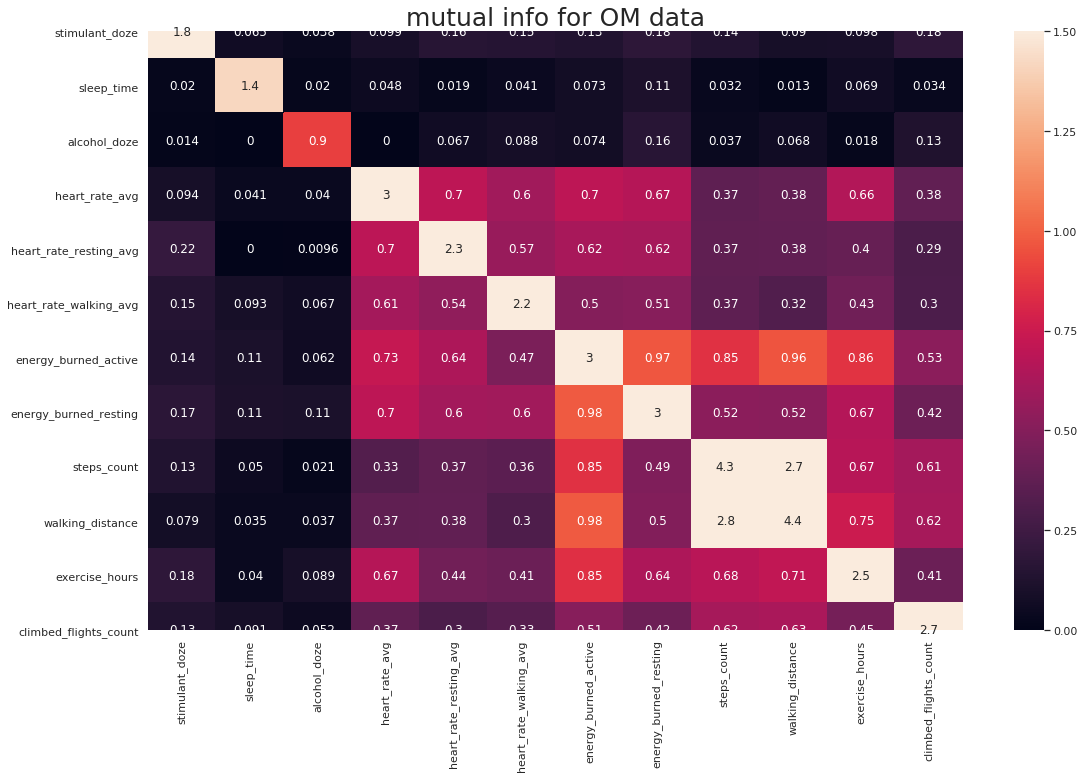

In [24]:
heatmap(mutual_infos_om, 'mutual info for OM data')

In [25]:
mutual_infos_cgn = mutual_infos(df_cgn)
mutual_infos_cgn

stimulant_doze  sleep_time  alcohol_doze  \
stimulant_doze                0.970974    0.052138      0.032432   
sleep_time                    0.000000    1.864955      0.005530   
alcohol_doze                  0.031283    0.000000      0.696202   
heart_rate_avg                0.036707    0.171215      0.042799   
heart_rate_resting_avg        0.029868    0.144548      0.009829   
heart_rate_walking_avg        0.022773    0.063812      0.022590   
energy_burned_active          0.101430    0.085236      0.038238   
energy_burned_resting         0.089924    0.112334      0.055050   
steps_count                   0.091473    0.064224      0.006360   
walking_distance              0.080176    0.100669      0.038339   
exercise_hours                0.073328    0.072479      0.020033   
climbed_flights_count         0.068873    0.008818      0.003229   

                        heart_rate_avg  heart_rate_resting_avg  \
stimulant_doze                0.024671                0.054660   
sleep_time                    0.186459                0.165554   
alcohol_doze                  0.042115                0.038787   
heart_rate_avg                5.396004                0.721402   
heart_rate_resting_avg        0.737404                3.410546   
heart_rate_walking_avg        0.328618                0.312754   
energy_burned_active          0.474621                0.434215   
energy_burned_resting         0.457148                0.414597   
steps_count                   0.241906                0.276914   
walking_distance              0.260509                0.281273   
exercise_hours                0.467115                0.382351   
climbed_flights_count         0.180339                0.135902   

                        heart_rate_walking_avg  energy_burned_active  \
stimulant_doze                        0.039825              0.074707   
sleep_time                            0.022279              0.097737   
alcohol_doze                          0.003827              0.038262   
heart_rate_avg                        0.328090              0.482766   
heart_rate_resting_avg                0.321708              0.431548   
heart_rate_walking_avg                3.573957              0.253133   
energy_burned_active                  0.232928              5.405653   
energy_burned_resting                 0.237915              0.817957   
steps_count                           0.222269              1.071388   
walking_distance                      0.218248              1.167332   
exercise_hours                        0.253540              1.006317   
climbed_flights_count                 0.134068              0.402089   

                        energy_burned_resting  steps_count  walking_distance  \
stimulant_doze                       0.091703     0.084108          0.080407   
sleep_time                           0.116946     0.070096          0.098992   
alcohol_doze                         0.066926     0.004035          0.033676   
heart_rate_avg                       0.452798     0.242257          0.266023   
heart_rate_resting_avg               0.421087     0.261557          0.279415   
heart_rate_walking_avg               0.239243     0.223050          0.210656   
energy_burned_active                 0.821303     1.071029          1.170291   
energy_burned_resting                5.396760     0.415813          0.434362   
steps_count                          0.413687     5.658772          2.278215   
walking_distance                     0.447936     2.283371          5.666821   
exercise_hours                       0.447777     0.824729          0.833663   
climbed_flights_count                0.279065     0.486123          0.463918   

                        exercise_hours  climbed_flights_count  
stimulant_doze                0.058894               0.042137  
sleep_time                    0.069997               0.055419  
alcohol_doze                  0.015862               0.024560  
heart_rate_avg                0.457149        

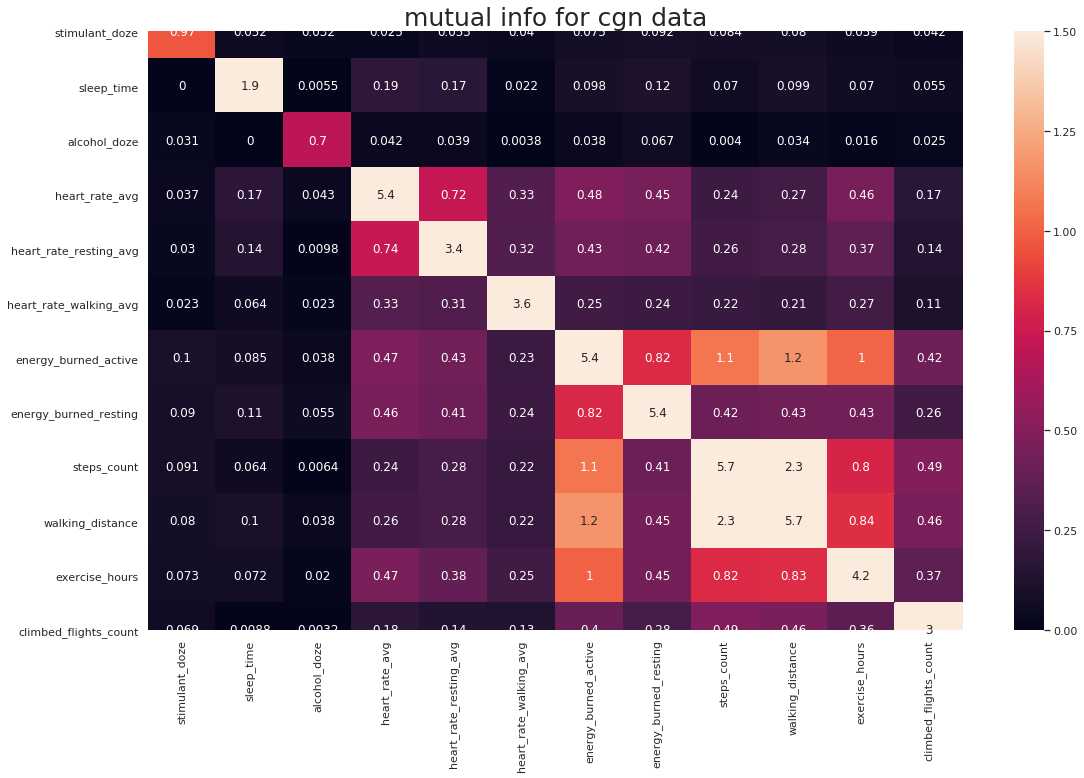

In [26]:
heatmap(mutual_infos_cgn, 'mutual info for cgn data')

## heatmap for users

In [27]:
## todo title for each

# for user_id in valid_ids:
#     df_user = df_om[df_om.user_id == user_id]
#     heatmap(mutual_infos(df_user), ('mutual info for user '+str(user_id)))

In [28]:
# for ID in valid_IDs:
#     df_user = df_cgn[df_cgn.ID == ID]
#     heatmap(mutual_infos(df_user), ('mutual info for user '+str(ID)))

## compare to correlation
Let's consider one fundamental concept of (linear) correlation, covariance (which is Pearson's correlation coefficient "un-standardized"). For two discrete random variables $X$ and $Y$ with probability mass functions $p(x)$, $p(y)$ and joint pmf $p(x,y)$ we have

$$\operatorname{Cov}(X,Y) = E(XY) - E(X)E(Y) = \sum_{x,y}p(x,y)xy - \left(\sum_xp(x)x\right)\cdot \left(\sum_yp(y)y\right)$$

$$\Rightarrow \operatorname{Cov}(X,Y) = \sum_{x,y}\left[p(x,y)-p(x)p(y)\right]xy$$

The Mutual Information between the two is defined as

$$I(X,Y) = E\left (\ln \frac{p(x,y)}{p(x)p(y)}\right)=\sum_{x,y}p(x,y)\left[\ln p(x,y)-\ln p(x)p(y)\right]$$

Compare the two: each contains a point-wise _measure_ of the distance of the two rv's from independence as it is expressed by the distance of the joint pmf from the product of the marginal pmf's: the $\operatorname{Cov}(X,Y)$ has it as difference of levels, while $I(X,Y)$ has it as difference of logarithms.  

And what do these measures do? In $\operatorname{Cov}(X,Y)$ they create a weighted sum of the product of the two random variables. In $I(X,Y)$ they create a weighted sum of their joint probabilities.

So with $\operatorname{Cov}(X,Y)$ we look at what non-independence does to their product, while in $I(X,Y)$ we look at what non-independence does to their joint probability distribution.  

Reversely, $I(X,Y)$ is the average value of the logarithmic measure of distance from independence, while $\operatorname{Cov}(X,Y)$ is the weighted value of the levels-measure of distance from independence, weighted by the product of the two rv's. 

So the two are not antagonistic&mdash;they are complementary, describing different aspects of the association between two random variables. One could comment that Mutual Information is not concerned whether the association is linear or not, while Covariance may be zero and the variables may still be stochastically dependent. On the other hand, Covariance can be calculated directly from a data sample without the need to actually know the probability distributions involved (since it is an expression involving moments of the distribution), while Mutual Information requires knowledge of the distributions, whose estimation, if unknown, is a much more delicate and uncertain work compared to the estimation of Covariance.

----------
  
source: [Stats.StackExchange: Mutual information versus correlation](https://stats.stackexchange.com/questions/81659/mutual-information-versus-correlation)


In [29]:
def pearsonr_features(df, f1, f2):
    df = df[~df[f1].isna() & ~df[f2].isna()]
    if df.size == 0:
        return np.nan
    df[f1] = df[f1].apply(lambda x: float(x))
    df[f2] = df[f2].apply(lambda x: float(x))
    return stats.pearsonr(df[f1], df[f2])

In [30]:
def correlation(df):
    rvalues = {}
    for f1 in lifestyle_features:
        temp_f1 = {}
        for f2 in lifestyle_features:
            if f1 == f2:
                temp_f1[f2] = np.nan
            else:
                temp_f1[f2], _ = pearsonr_features(df, f1, f2)
        rvalues[f1] = temp_f1

    return pd.DataFrame(rvalues)

In [31]:
correlation(df_om)

/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


stimulant_doze  sleep_time  alcohol_doze  \
stimulant_doze                     NaN    0.058147      0.273432   
sleep_time                    0.058147         NaN      0.003732   
alcohol_doze                  0.273432    0.003732           NaN   
heart_rate_avg                0.356117    0.145081      0.171426   
heart_rate_resting_avg        0.376612    0.097061      0.204258   
heart_rate_walking_avg        0.359810    0.088083      0.209308   
energy_burned_active          0.291121   -0.061430      0.364923   
energy_burned_resting         0.459016    0.019692      0.346450   
steps_count                   0.160241   -0.037453      0.301373   
walking_distance              0.181310   -0.051121      0.317323   
exercise_hours                0.075767   -0.000747      0.194638   
climbed_flights_count         0.180131   -0.085688      0.374628   

                        heart_rate_avg  heart_rate_resting_avg  \
stimulant_doze                0.356117                0.376612   
sleep_time                    0.145081                0.097061   
alcohol_doze                  0.171426                0.204258   
heart_rate_avg                     NaN                0.807745   
heart_rate_resting_avg        0.807745                     NaN   
heart_rate_walking_avg        0.791847                0.743100   
energy_burned_active          0.663359                0.566512   
energy_burned_resting         0.850379                0.826782   
steps_count                   0.515849                0.430675   
walking_distance              0.532098                0.433314   
exercise_hours                0.522395                0.365712   
climbed_flights_count         0.487170                0.390906   

                        heart_rate_walking_avg  energy_burned_active  \
stimulant_doze                        0.359810              0.291121   
sleep_time                            0.088083             -0.061430   
alcohol_doze                          0.209308              0.364923   
heart_rate_avg                        0.791847              0.663359   
heart_rate_resting_avg                0.743100              0.566512   
heart_rate_walking_avg                     NaN              0.646632   
energy_burned_active                  0.646632                   NaN   
energy_burned_resting                 0.787094              0.810713   
steps_count                           0.534046              0.792969   
walking_distance                      0.543176              0.841927   
exercise_hours                        0.488354              0.848670   
climbed_flights_count                 0.484126              0.741614   

                        energy_burned_resting  steps_count  walking_distance  \
stimulant_doze                       0.459016     0.160241          0.181310   
sleep_time                           0.019692    -0.037453         -0.051121   
alcohol_doze                         0.346450     0.301373          0.317323   
heart_rate_avg                       0.850379     0.515849          0.532098   
heart_rate_resting_avg               0.826782     0.430675          0.433314   
heart_rate_walking_avg               0.787094     0.534046          0.543176   
energy_burned_active                 0.810713     0.792969          0.841927   
energy_burned_resting                     NaN     0.612682          0.635542   
steps_count                          0.612682          NaN          0.987456   
walking_distance                     0.635542     0.987456               NaN   
exercise_hours                       0.528809     0.699792          0.737459   
climbed_flights_count                0.575569     0.677913          0.735839   

                        exercise_hours  climbed_flights_count  
stimulant_doze                0.075767               0.180131  
sleep_time                   -0.000747              -0.085688  
alcohol_doze                  0.194638               0.374628  
heart_rate_avg                0.522395        

/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/qasem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


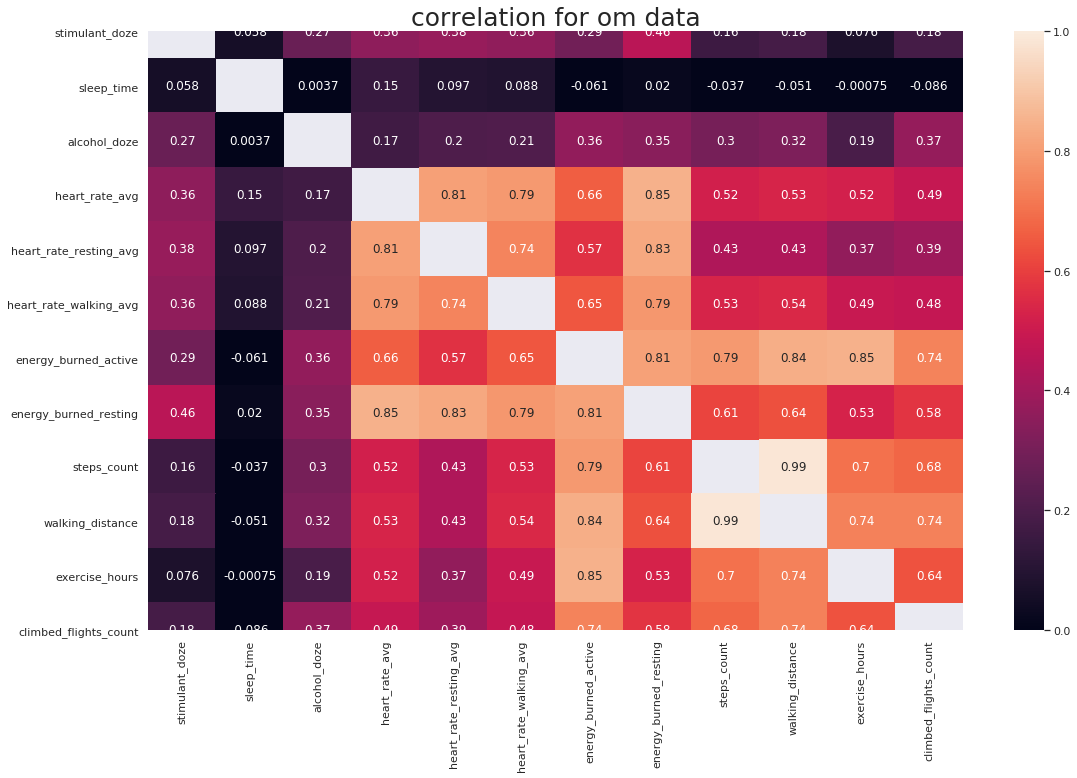

In [32]:
heatmap(correlation(df_om), 'correlation for om data', vmax=1)

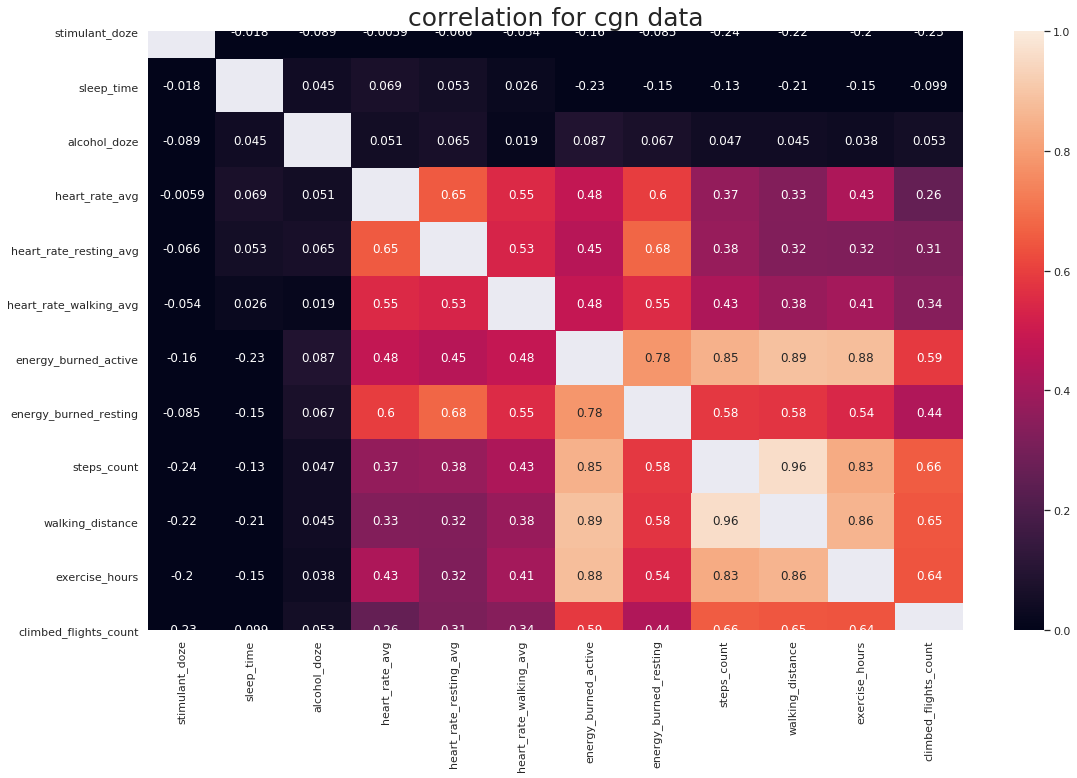

In [33]:
heatmap(correlation(df_cgn), 'correlation for cgn data', vmax=1)

## network features

In [34]:
def network(df, title):
    G = nx.DiGraph()
    for f1 in lifestyle_features:
        for f2 in lifestyle_features:
            if f1 == f2:
                continue
            else:
                G.add_edges_from([(f1, f2)],
                                 weight=mutual_info_features(df, f1, f2))

    val_map = information(df, lifestyle_features)
    values = [val_map.get(node, 0.45) for node in G.nodes()]
    color_map = values
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    pos = nx.spring_layout(G)
    plt.figure(figsize=(17, 9))
    set_title = 'graph of mutual information for ' + str(title)
    plt.title(set_title, fontsize=25)
    nx.draw(G, pos, node_size=1200,
            with_labels=True, node_color=color_map,
            edge_color=weights,
            edge_cmap=plt.cm.Reds)
#     plt.savefig('rv_for_user.png')
    pylab.show()

In the following graphs for each user
- `edge-color` shows the inverse of mutual information between two nodes
- `edge-length` also shows the inverse of mutual information between two nodes
- `node-color` shows the _information_ of each node. the brighter, the more infomation it carries.

/home/qasem/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/qasem/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/qasem/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/qasem/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_

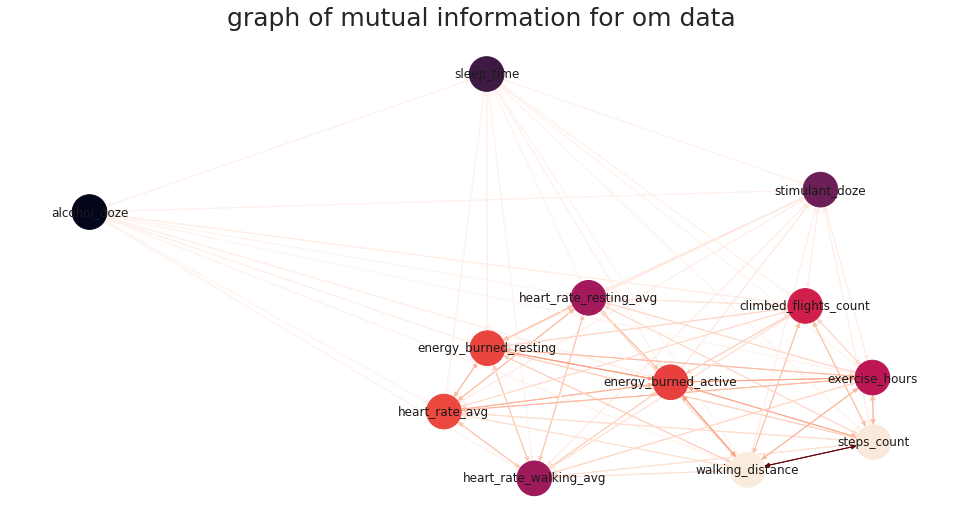

In [35]:
network(df_om, 'om data')

In [36]:
# for user_id in valid_ids:
#     df_user = df_om[df_om.user_id == user_id]
#     network(df_user, ('user '+str(user_id)))

In [37]:
# for ID in valid_IDs:
#     df_user = df_cgn[df_cgn.ID == ID]
#     network(df_user, ('user '+str(ID)))

# causal model
I suppose, it's what we're looking for. I tried these two tools for it.

ideas

joint distribution:
multi-var gaussian: let's show it

explore data;
causal model!
beysian net field;
find structure
(library)
use mutual info to train the above

graphical models

add latent hidden variable to problem
#first find subp var and then 
#mix of some multi-gaussian distributions
#EM to learn # of populations, for gaussian

#SMOOTH distribution to make entropy normalized

needs so much samples;
use mutual info to train it.

## pgmpy

In [43]:
# import sys
# !{sys.executable} -m pip install pgmpy --user

In [44]:
# from pgmpy.models.BayesianModel import BayesianModel
# from pgmpy.factors.discrete import TabularCPD
# from pgmpy.sampling import BayesianModelSampling

# student = BayesianModel([('diff', 'grade'), ('intel', 'grade')])

# cpd_d = TabularCPD('diff', 2, [[0.6], [0.4]])
# cpd_i = TabularCPD('intel', 2, [[0.7], [0.3]])
# cpd_g = TabularCPD('grade', 3, [[0.3, 0.05, 0.9, 0.5], [0.4, 0.25, 0.08, 0.3], [0.3, 0.7, 0.02, 0.2]], ['intel', 'diff'], [2, 2])

# student.add_cpds(cpd_d, cpd_i, cpd_g)
# inference = BayesianModelSampling(student)
# df_samples = inference.forward_sample(size=20, return_type='recarray')

# print(df_samples)

# Manifold learning, nonlinear dim reduction

/home/qasem/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


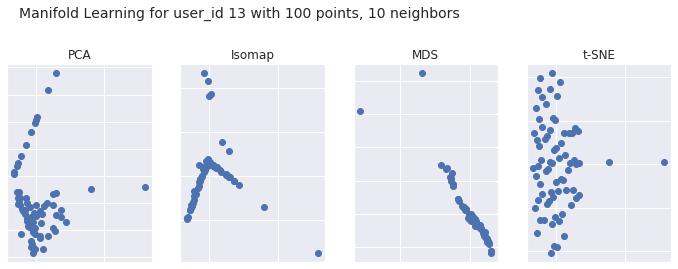

In [45]:
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets
from sklearn.decomposition import PCA


def plot_manifold(df, user_id):
    #     try:
    #         df_user = df[df.ID == user_id]
    #     except:
    #         df_user = df[df.user_id == user_id]

    df_user = df[df.user_id == user_id]

    n_points = 100
    # X, color = datasets.make_s_curve(n_points, random_state=0)
    df_user = df_user[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
        'score']]
    df_user = df_user.dropna()
#     print(df_user)
    X, _ = df_user[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
    ]], np.array(df_user[['score']])/100*255
    n_neighbors = 10
    n_components = 2

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Manifold Learning for user_id %i with %i points, %i neighbors"
                 % (user_id, n_points, n_neighbors), fontsize=14)

    # Set-up manifold methods
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')

    methods = {}
    methods['PCA'] = PCA(n_components=2, svd_solver='full')
    # pca.fit(X)

    # methods['LLE'] = LLE(method='standard')
    # methods['LTSA'] = LLE(method='ltsa')
    # methods['Hessian LLE'] = LLE(method='hessian')
    # methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    # methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
    #                                            n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        Y = method.fit_transform(X)
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1],
#                    c=color,
                   cmap=plt.cm.Spectral)
        ax.set_title("%s" % label)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()


plot_manifold(df_om, 13)

/home/qasem/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


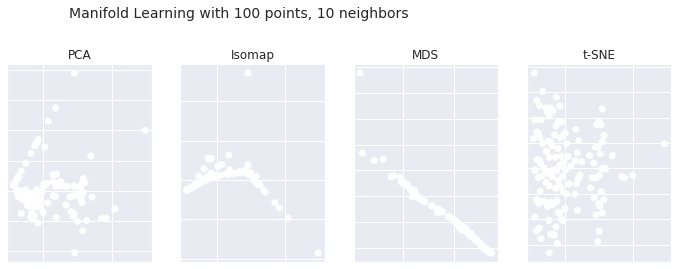

In [46]:
import matplotlib.colors as colors
import matplotlib.cm as cmx


def plot_manifold_users(df):

    # Get unique names of species
    uniq = list(set(df['user_id']))

    # Set the color map to match the number of species
    z = range(1, len(uniq))
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    n_points = 100
    # X, color = datasets.make_s_curve(n_points, random_state=0)
    df = df[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
        'user_id',
        'score']]
    df = df.dropna()
    X, _ = df[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
    ]], np.array(df[['score']])/100*255
    n_neighbors = 10
    n_components = 2

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    # Set-up manifold methods
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')

    methods = {}
    methods['PCA'] = PCA(n_components=2, svd_solver='full')
    # pca.fit(X)

    # methods['LLE'] = LLE(method='standard')
    # methods['LTSA'] = LLE(method='ltsa')
    # methods['Hessian LLE'] = LLE(method='hessian')
    # methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
    # methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
    #                                            n_neighbors=n_neighbors)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        Y = method.fit_transform(X)
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1],
#                    c=color,
#                    c=df[['user_id']].apply(lambda x: 'red'),
                   c=scalarMap.to_rgba(df['user_id']),
#                    c=['red', 'green'].to_rgba(df['user_id']),
                   cmap=plt.cm.Spectral)
        ax.set_title("%s" % label)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()


plot_manifold_users(df_om[df_om.user_id.isin(valid_ids)])

## plot PCA, t-SNE, isomap

/home/qasem/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10, n_components=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


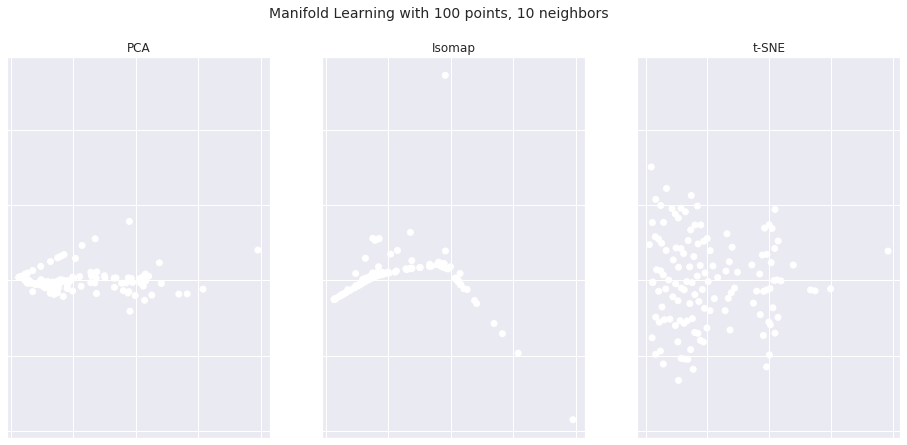

In [47]:
def plot_manifolds(df):

    # Get unique names of species
    uniq = list(set(df['user_id']))

    # Set the color map to match the number of species
    z = range(1, len(uniq))
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    n_points = 100
    # X, color = datasets.make_s_curve(n_points, random_state=0)
    df = df[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
        'user_id',
        'score']]
    df = df.dropna()
    X, _ = df[[
        'stimulant_doze',
        'sleep_time',
        'alcohol_doze',
        'heart_rate_avg',
        'energy_burned_active',
        'steps_count',
    ]], np.array(df[['score']])/100*255
    n_neighbors = 10
    n_components = 2

    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
#     axs[0].bar(names, values)
#     axs[1].scatter(names, values)
#     axs[2].plot(names, values)    
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    
    # Set-up manifold methods
    LLE = partial(manifold.LocallyLinearEmbedding,
                  n_neighbors, n_components, eigen_solver='auto')

    methods = {}
    methods['PCA'] = PCA(n_components=2, svd_solver='full')
    # methods['LLE'] = LLE(method='standard')
    # methods['LTSA'] = LLE(method='ltsa')
    # methods['Hessian LLE'] = LLE(method='hessian')
    # methods['Modified LLE'] = LLE(method='modified')
    methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
    methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                     random_state=0)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        Y = method.fit_transform(X)
#         ax = fig.add_subplot(1, 5, 2 + i + (i > 3))
        ax[i].scatter(Y[:, 0], Y[:, 1],
#                    c=color,
#                    c=df[['user_id']].apply(lambda x: 'red'),
                   c=scalarMap.to_rgba(df['user_id']),
#                    c=['red', 'green'].to_rgba(df['user_id']),
                   cmap=plt.cm.Spectral)
        ax[i].set_title("%s" % label)
        ax[i].xaxis.set_major_formatter(NullFormatter())
        ax[i].yaxis.set_major_formatter(NullFormatter())
        ax[i].axis('tight')

    plt.show()


plot_manifolds(df_om[df_om.user_id.isin(valid_ids)])

- early predict the cluster for user
- are they clustered? let's plot them
- t-SNE for all tests
- plot the errors for # of clusters
- cluster the tests IID by k-means, GMM, or EM
- in each cluster, find two most important features
- make a posterior knowledge based on the prior of all population

# feature importance in a random forest regressor

In [48]:
# import sys
# !{sys.executable} -m pip install --upgrade scikit-learn --user
# !{sys.executable} -m pip install scikit-learn==0.23.2 --user
# !{sys.executable} -m pip3 install -U scikit-learn --user
# !{sys.executable} -m pip uninstall sklearn

import sklearn
sklearn.__version__

'0.23.2'

Now we only have put the `score` into the target.

The method you are trying to apply is using built-in feature importance of Random Forest. This method can sometimes prefer numerical features over categorical and can prefer high cardinality categorical features. Please see this [article](https://explained.ai/rf-importance/) for details. There are two other methods to get feature importance (but also with their pros and cons).

## Feature Importance

In `scikit-learn` from version `0.22` there is method: [`permutation_importance`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). It is model agnostic. It can even work with algorithms from other packages if they follow the `scikit-learn` interface.

The permutation-based importance can be computationally expensive and can omit highly correlated features as important.

source: [scikit-learn: Feature importances with forests of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

source: [Random Forest Feature Importance Computed in 3 Ways with Python](https://mljar.com/blog/feature-importance-in-random-forest/)

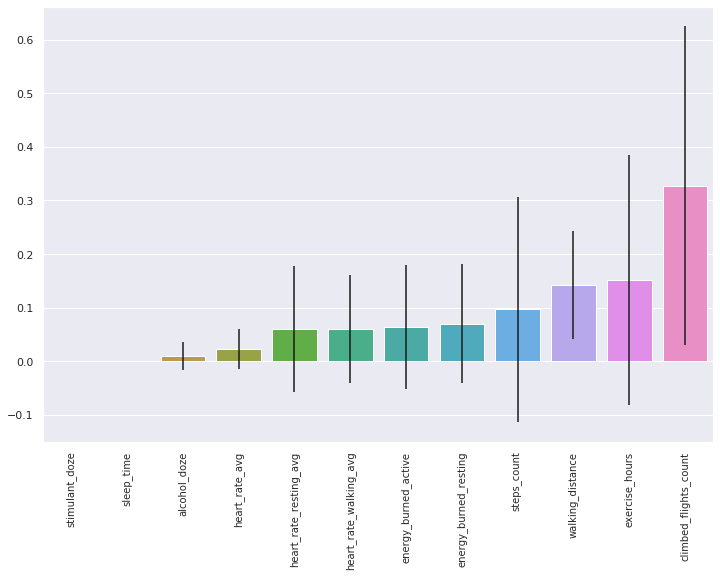

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance
import copy


def plot_feature_importance(df):
    # prepare the data
    #     boston = load_boston()
    # X = pd.DataFrame(boston.data, columns=boston.feature_names)
    #     df1 = pd.DataFrame()
#     df1 = df.copy()
#     for f in lifestyle_features:
#         df1[f] = df1[df1[f] != np.nan]

#     X = df1[lifestyle_features]
#     y = df1[['score']]

    df3 = copy.deepcopy(df)
 #   df_test = pd.DataFrame()
    df3 = df3[score_lifestyle_features].dropna(axis=0)
    
#     features = ['sleep_time', 'alcohol_doze', 'heart_rate_avg',
#                 'stimulant_doze', 'energy_burned_active', 'exercise_hours']
    features = lifestyle_features
    X = df3[features]
    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]
    
    X = df3[features]
    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=12)

    # train the model
    rf = RandomForestRegressor(n_estimators=20,max_depth=5)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    std = np.std(
        [tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

#     plt.figure(figsize=(11, 7))
#     plt.title("Feature_importances_")
#     plt.bar(range(X.shape[1]), importances[indices],
#             color="r", yerr=std[indices], align="center")
#     plt.xticks(range(X.shape[1]), indices)
#     plt.xlim([-1, X.shape[1]])
#     plt.show()

    sorted_idx = rf.feature_importances_.argsort()
    plt.figure(figsize=(12, 8))
    sns.barplot(lifestyle_features,
                rf.feature_importances_[sorted_idx],
                yerr=std[sorted_idx],)
    plt.xticks(rotation=90, fontsize=10)

    # the permutation based importance
#     perm_importance = permutation_importance(rf, X_test, y_test)
#
#     sorted_idx = perm_importance.importances_mean.argsort()
#     plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
#     plt.xlabel("Permutation Importance")


plot_feature_importance(df_om[df_om.user_id==40])

## permutaion test importance

In [52]:
from collections import defaultdict
import array

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# data = load_breast_cancer()
# data.feature_names
# array(lifestyle_features)

TypeError: 'module' object is not callable

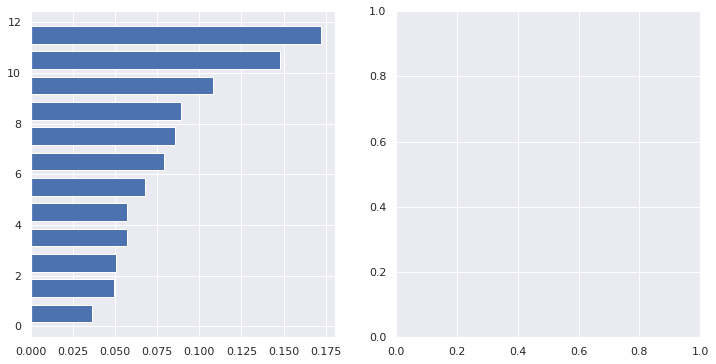

In [53]:
from sklearn.inspection import permutation_importance


def permutation_importances(df):
#     df3 = df.copy()
#     for f in lifestyle_features:
#         df3[f] = df3[df3[f] != np.nan]
    
    df3 = copy.deepcopy(df)
 #   df_test = pd.DataFrame()
    df3 = df3[score_lifestyle_features].dropna(axis=0)
    
#     features = ['sleep_time', 'alcohol_doze', 'heart_rate_avg',
#                 'stimulant_doze', 'energy_burned_active', 'exercise_hours']
    features = lifestyle_features
    X = df3[features]
    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]
    
    X = df3[features]
    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=12)

  
    # train the model
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)

    result = permutation_importance(
        rf, X_train, y_train, n_repeats=10, random_state=42)

    perm_sorted_idx = result.importances_mean.argsort()

    tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
    tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.barh(tree_indices,
             rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
    ax1.set_yticklabels(array(features)[tree_importance_sorted_idx])
    ax1.set_yticks(tree_indices)
    ax1.set_ylim((0, len(rf.feature_importances_)))
    ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
                labels=array(features)[perm_sorted_idx])
    fig.tight_layout()
    plt.show()
    


permutation_importances(df_om)

- Handling Multicollinear Features

When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. First, we plot a heatmap of the correlated features

- <a href="https://link.springer.com/article/10.1186%2F1471-2105-8-25" >Random Forest </a> feature importances

_We show that random forest variable importance measures are a sensible means for variable selection in many applications, but are not reliable in situations where potential predictor variables vary in their scale of measurement or their number of categories._

This is saying that if a feature varies on its ability to detect based on class it will be fault. This seems to imply the methodology is sensitive to data outliers like maybe a feature if 90% responsible for classification of 5% of the variables it may be the most important feature even though that might not really be accurate.

- Permutation importances by <a href="https://scikit-learn.org/dev/modules/permutation_importance.html" > Scikit-learn </a>

_Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is rectangular.
This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature._

The data being rectangular means it is a multivariate feature array table. The model working in non linear scenarios means it is able to be beneficial in prediction even when outputs follow non linear functions like XOR. 


source: [DataScience.StackExchange](https://datascience.stackexchange.com/questions/63024/permutation-feature-importance-vs-randomforest-feature-importance)

## shapley based importance

Feature Importance can be computed with Shapley values (you need [`shap`](https://github.com/slundberg/shap) package).

source: [shapley values, interpretable machine learning](https://christophm.github.io/interpretable-ml-book/shapley.html#shapley)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


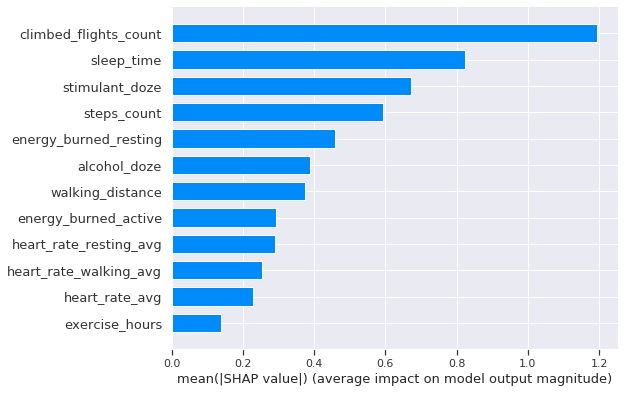

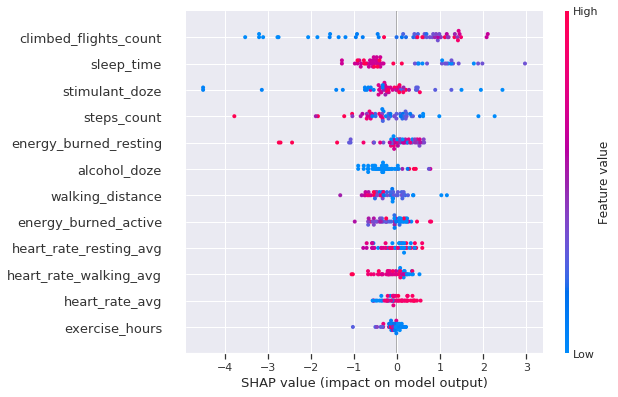

In [60]:
import shap
import copy

def shapely_value(df):
    # prepare the data
    #     boston = load_boston()
    # X = pd.DataFrame(boston.data, columns=boston.feature_names)
    
#     print(lifestyle_features)
#     print("********************************")
    df3 = copy.deepcopy(df)
 #   df_test = pd.DataFrame()
    df3 = df3[score_lifestyle_features].dropna(axis=0)
    
#     features = ['sleep_time', 'alcohol_doze', 'heart_rate_avg',
#                 'stimulant_doze', 'energy_burned_active', 'exercise_hours']
    features = lifestyle_features
    X = df3[features]
    y = df3[['score']]
    y = np.array(y).reshape(1, -1)[0]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=2)

    n_estimators = 500
    rg = RandomForestRegressor(n_estimators=n_estimators, random_state=42, criterion='mae')
    rg.fit(X_train, y_train)

#     print('Nnum of estimators is', n_estimators)
#     print("Accuracy on train data: {:.2f}".format(rg.score(X_train, y_train)))
#     print("Accuracy on test data: {:.2f}".format(rg.score(
#         np.array(X_test).astype(int),
#         np.array(y_test).astype(int)
#     )))
# #     you can try selecting features, then monitoring the test accuracy

    explainer = shap.TreeExplainer(rg)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)
    shap.force_plot(explainer.expected_value, shap_values, X)


shapely_value(df_om)

# joint distribution

In [ ]:
def distribution(df, f):
    plt.figure(figsize=(11, 7))
    sns.distplot(df[~df[f].isna()][f])
    plt.show()


fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))

ax0.set_title('exercise_hours')
ax0 = sns.distplot(df_om[~df_om['exercise_hours'].isna()]['exercise_hours'])

ax1.set_title('steps_count')
ax1 = sns.distplot(df_om[~df_om['exercise_hours'].isna()]['exercise_hours'])

ax2.set_title('climbed_flights')
ax2 = sns.distplot(df_om[~df_om['exercise_hours'].isna()]['exercise_hours'])

for f in lifestyle_features:
    distribution(df_om, f)
df_om.exercise_hours


In [ ]:
def joint_distribution(df, f1, f2):
    plt.figure()
    sns.jointplot(f1, f2, data=df[~df[f1].isna()&~df[f2].isna()], kind='reg')
    plt.show()
    
joint_distribution(df_om, 'exercise_hours', 'heart_rate_avg')

The aim is to understand the joint distribution of all those features.

# metrics vs features

In [55]:
metrics = ['score',
           'accuracy',
           'speed',
           'mean_rt',
           'no_responses_count',
           'outliers_count',
           'images_tested',
           ]

In [56]:
def metric_feature(df, features, metrics):
    df = df.replace('not_set', np.nan)
    metric_feature_s = {}
    metric_feature_rv = {}
    metric_feature_pv = {}

    for f in features:
        temp = {}
        temp_s = {}
        temp_rv = {}
        temp_pv = {}
        for m in metrics:
            temp[m] = stats.linregress(df[~df[f].isna()][f].apply(lambda x: float(x)),
                                       df[~df[f].isna()][m])
            temp_s[m] = temp[m].slope
            temp_rv[m] = temp[m].rvalue
            temp_pv[m] = temp[m].pvalue
            
        metric_feature_s[f] = temp_s
        metric_feature_rv[f] = temp_rv
        metric_feature_pv[f] = temp_pv

    return pd.DataFrame(metric_feature_s), pd.DataFrame(metric_feature_rv), pd.DataFrame(metric_feature_pv)

mf_s, mf_rv, mf_pv = metric_feature(df_om, lifestyle_features, metrics)

mf_rv

stimulant_doze  sleep_time  alcohol_doze  heart_rate_avg  \
score                 0.092048    0.077789      0.035532        0.171748   
accuracy                 -0.109660   -0.011746      0.111572        0.053250   
speed                     0.274225    0.132597     -0.077414        0.248246   
mean_rt                  -0.278342   -0.128377      0.102257       -0.194849   
no_responses_count       -0.053284   -0.189976     -0.036114       -0.118015   
outliers_count           -0.260417   -0.141400      0.044662       -0.274510   
images_tested            -0.313427   -0.217750     -0.109781       -0.327946   

                    heart_rate_resting_avg  heart_rate_walking_avg  \
score                         0.145031                0.152625   
accuracy                          0.051137                0.076351   
speed                             0.206829                0.230551   
mean_rt                          -0.154376               -0.107310   
no_responses_count               -0.099834               -0.091903   
outliers_count                   -0.248524               -0.216181   
images_tested                    -0.268007               -0.246529   

                    energy_burned_active  energy_burned_resting  steps_count  \
score                       0.094553               0.152065     0.123171   
accuracy                        0.032459               0.051281     0.086909   
speed                           0.161311               0.232939     0.162695   
mean_rt                        -0.099357              -0.164256    -0.059147   
no_responses_count             -0.076291              -0.103502    -0.095950   
outliers_count                 -0.106286              -0.225795    -0.053542   
images_tested                  -0.148522              -0.257380    -0.065031   

                    walking_distance  exercise_hours  climbed_flights_count  
score                   0.125249        0.091986               0.168417  
accuracy                    0.082994        0.053672               0.102927  
speed                       0.165838        0.114408               0.181830  
mean_rt                    -0.067064       -0.062541              -0.091068  
no_responses_count         -0.093627       -0.058253              -0.079405  
outliers_count             -0.060911       -0.030067              -0.116215  
images_tested              -0.073380       -0.107208              -0.138022

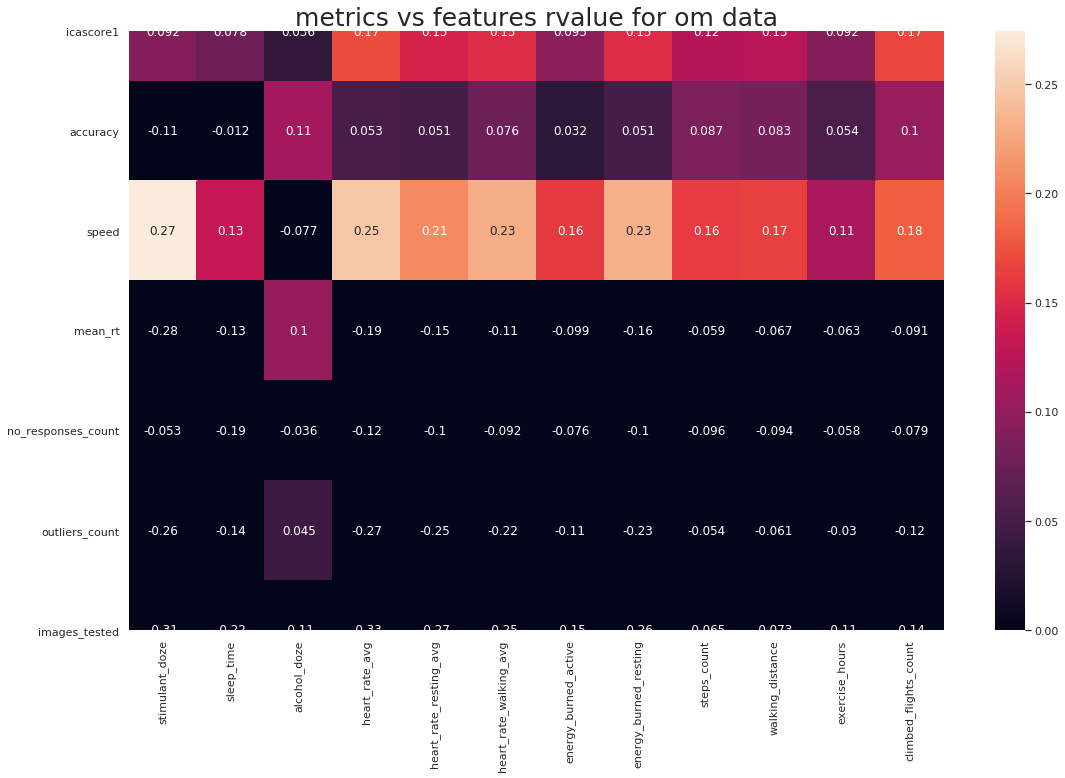

In [57]:
heatmap(mf_rv, 'metrics vs features rvalue for om data', vmax=None)

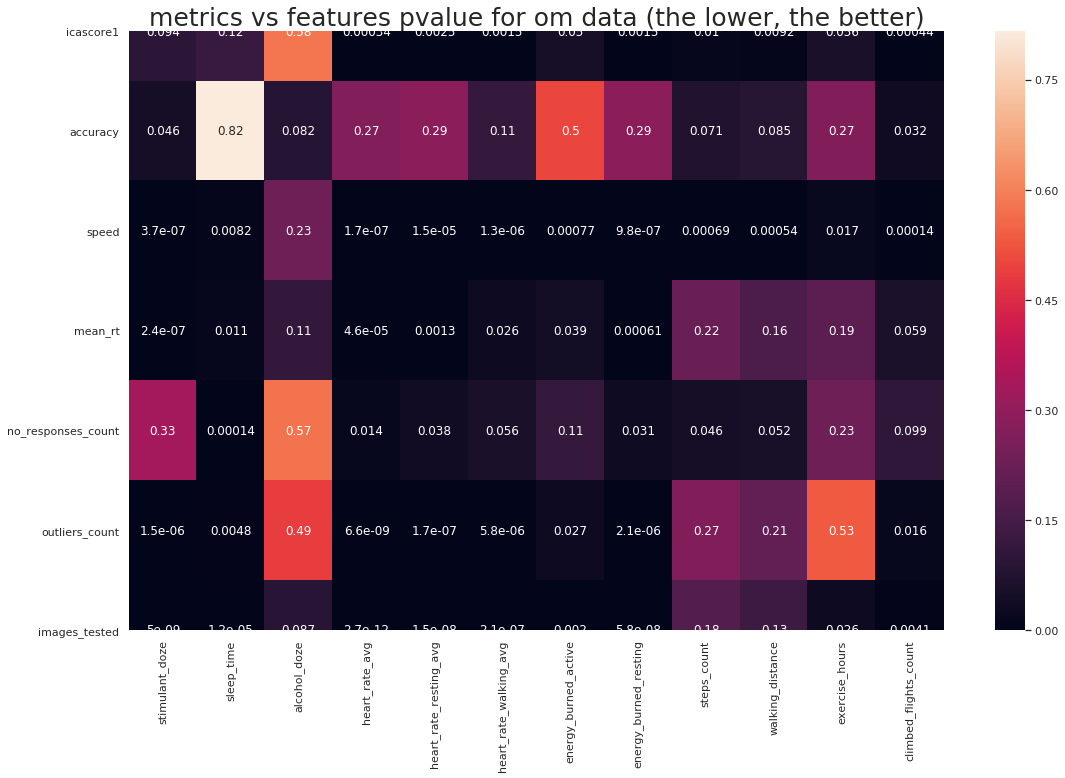

In [58]:
heatmap(mf_pv, 'metrics vs features pvalue for om data (the lower, the better)', vmax=None)

# bi-features
We simply try to select two features to make better prediction for `score`

In [ ]:
def bi_reg(df, f1, f2):
    x1_plot = x1 = np.array(df[~df[f1].isna() & ~df[f2].isna()][f1].apply(lambda x: float(x)))
    x2_plot = x2 = np.array(df[~df[f1].isna() & ~df[f2].isna()][f2].apply(lambda x: float(x)))
    y = np.array(df[~df[f1].isna() & ~df[f2].isna()]['score'])
    X1_plot = X1 = x1.reshape(-1, 1)
    X2_plot = X2 = x2.reshape(-1, 1)
    X = np.concatenate((X1, X2), axis=1)
    lw = 1

    plt.figure(figsize=(11, 7))
    plt.xlim(x1.min(), x1.max())
    plt.scatter(X1, y, color='navy', s=20, marker='o', label="datapoints")

    reg = LinearRegression().fit(X, y)
    y_plot = reg.predict(X)
    plt.plot(x1_plot, y_plot, color='gold', linewidth=lw)
    
    plt.legend(loc='lower left')

    plt.show()
    
    return reg, reg.score(X, y)


reg, score = bi_reg(df_om, 'climbed_flights_count', 'exercise_hours')
reg.predict([[10, 1]])[0]
# for 10 climbed_f and 1 hour of exercise, it's the linear prediction

In [ ]:
def lin_reg_score(df, f1, f2):
    x1_plot = x1 = np.array(df[~df[f1].isna() & ~df[f2].isna()][f1].apply(lambda x: float(x)))
    x2_plot = x2 = np.array(df[~df[f1].isna() & ~df[f2].isna()][f2].apply(lambda x: float(x)))
    y = np.array(df[~df[f1].isna() & ~df[f2].isna()]['score'])
    X1_plot = X1 = x1.reshape(-1, 1)
    X2_plot = X2 = x2.reshape(-1, 1)
    X = np.concatenate((X1, X2), axis=1)
    lw = 1
    reg = LinearRegression().fit(X, y)    
    return reg.score(X, y)

In [ ]:
def bifactor_score(df):   
    bifactor_score = {}
    for f1 in lifestyle_features:
        temp_f1 = {}
        for f2 in lifestyle_features:
    #         if f1 == f2:
    #             continue
    #         else:
            temp_f1[f2] = lin_reg_score(df, f1, f2)
        bifactor_score[f1] = temp_f1
    return pd.DataFrame(bifactor_score)


bifactor_score(df_om)

In [ ]:
heatmap(bifactor_score(df_om[df_om.alcohol_doze=='0']),
        "non-alcohol-dirnkers' score of linear model with only these two features",vmax=None)

In [ ]:
heatmap(bifactor_score(df_om[df_om.alcohol_doze!='0']),
        "alcohol-dirnkers' score of linear model with only these two features",vmax=None)